In [4]:
library(tidyverse)
library(h2o)

In [5]:
library("pca3d")

In [6]:
ggplot2::theme_set(ggplot2::theme_light())

In [7]:
url <- "https://koalaverse.github.io/homlr/data/my_basket.csv"
my_basket <- readr::read_csv(url)
dim(my_basket) 

Rows: 2000 Columns: 42
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (42): 7up, lasagna, pepsi, yop, red.wine, cheese, bbq, bulmers, mayonnai...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 2000   42

## 차원축소
- 데이터는 tidy해야함
- 데이터에 결측치가 없어야함
- 모든 데이터는 수치형(원-핫 레이블, 순서인코딩)
- 수치형 데이터는 표준화되어야함

- 변수간의 공분산을 검사하고, 여러 변수를 상관되지 않은 더 작은 변수집합으로 결합
- 새로운 변수를 주성분 (PC)이라고 하며, (전체 변수 세트의 변동성을 대부분 설명할 수 있는 작은 부분 집합)
- PC를 형성하는 데 사용된 가중치는 새 PC에 대한 원래 기능의 상대적 기여도를 나타냄

In [8]:
head(my_basket)

7up,lasagna,pepsi,yop,red.wine,cheese,bbq,bulmers,mayonnaise,horlics,...,instant.coffee,twix,potatoes,fosters,soup,toad.in.hole,coco.pops,kitkat,broccoli,cigarettes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
0,0,0,2,1,0,0,0,0,0,...,0,2,0,1,0,0,0,1,0,1
0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 항목별 상관관계

In [9]:
m <- cor(my_basket)

In [10]:
m2 <- data.frame(
  row = rownames(m)[row(m)[upper.tri(m)]],
  col = colnames(m)[col(m)[upper.tri(m)]],
  corr = m[upper.tri(m)],
  stringsAsFactors = FALSE
  )
m2 %>% 
    filter(corr < 1 & corr > .25) %>%
    rename('item1' = row, 'item2' = col) %>%
    arrange(desc(corr)) %>% head

,item1,item2,corr
,<chr>,<chr>,<dbl>
1,cheese,mayonnaise,0.3453348
2,bulmers,fosters,0.3345945
3,cheese,bread,0.3197041
4,lasagna,pizza,0.3157526
5,pepsi,coke,0.3088455
6,red.wine,fosters,0.3082377


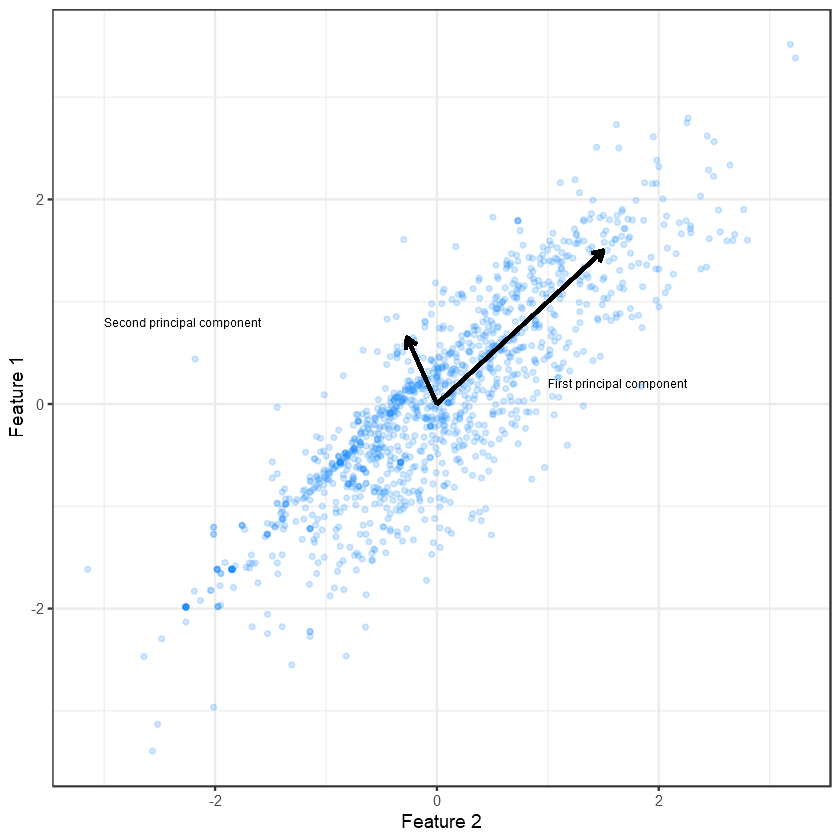

In [11]:
df <- AmesHousing::make_ames() %>%
  select(var1 = First_Flr_SF, var2 = Gr_Liv_Area) %>%
  filter(var1 != var2) %>%
  mutate_all(log) %>%
  scale() %>% 
  data.frame() %>%
  filter(var1 < 4)
ggplot(df, aes(var1, var2)) +
  geom_jitter(alpha = .2, size = 1, color = "dodgerblue") +
  geom_segment(
    aes(x = 0, xend = 1.5 , y = 0, yend = 1.5),
    arrow = arrow(length = unit(0.25,"cm")), size = 0.75, color = "black"
    ) +
  annotate("text", x = 1, y = .2, label = "First principal component", size = 2.5, hjust = 0) +
  annotate("text", x = -3, y = .8, label = "Second principal component", size = 2.5, hjust = 0) +
  geom_segment(
    aes(x = 0, xend = -0.27 , y = 0, yend = .65),
    arrow = arrow(length = unit(0.25,"cm")), size = 0.75, color = "black"
    ) +
  xlab("Feature 2") +
  ylab("Feature 1") +
  theme_bw()

In [21]:
df <- AmesHousing::make_ames() %>%
  select(var1 = First_Flr_SF, var2 = Gr_Liv_Area, var3 = TotRms_AbvGrd) %>%
  filter(var1 != var2) %>%
  mutate_at(vars(var1, var2), log)

pca <- prcomp(df, scale = FALSE)
pca3d(pca)

[1] 0.135693940 0.022140269 0.009712809
Creating new device


<img src = "https://bradleyboehmke.github.io/HOML/images/3D-PCA.png">

### PCA

In [12]:
h2o.no_progress()
h2o.init(max_mem_size = "5g")

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         43 minutes 29 seconds 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_started_from_R_apf_temp_admin_trg721 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.42 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.1.3 (2022-03-10) 



### ```h2o.prcomp()```
- ```pca_method``` : 사용할 PC방식을 지정, (데이터에 수치형변수가 많을 경우 ```"GramSVD"```, 범주형변수가 많은 경우```"GLRM"```)
- ```k``` : 계산할 PC의 수, 변수의 개수만큼 만드는 것이 가장 좋음
- ```transform``` : 데이터가 표준화되어야 하는 방식
- ```impute_missing``` : 결측값을 대체할지 여부 (TRUE / FALSE)
- ```max_runtime_secs``` : 최대 실행시간 지정 (런타임 제한)

In [13]:
my_basket.h2o <- as.h2o(my_basket)

In [14]:
my_pca <- h2o.prcomp(
  training_frame = my_basket.h2o,
  pca_method = "GramSVD",
  k = ncol(my_basket.h2o), 
  transform = "STANDARDIZE", 
  impute_missing = TRUE,
  max_runtime_secs = 1000
)

In [15]:
my_pca

Model Details:

H2ODimReductionModel: pca
Model ID:  PCA_model_R_1649355762627_1 
Importance of components: 
                            pc1      pc2      pc3      pc4      pc5      pc6
Standard deviation     1.513919 1.473768 1.459114 1.440635 1.435279 1.411544
Proportion of Variance 0.054570 0.051714 0.050691 0.049415 0.049048 0.047439
Cumulative Proportion  0.054570 0.106284 0.156975 0.206390 0.255438 0.302878
                            pc7      pc8      pc9     pc10     pc11     pc12
Standard deviation     1.253307 1.026387 1.010238 1.007253 0.988724 0.985320
Proportion of Variance 0.037400 0.025083 0.024300 0.024156 0.023276 0.023116
Cumulative Proportion  0.340277 0.365360 0.389659 0.413816 0.437091 0.460207
                           pc13     pc14     pc15     pc16     pc17     pc18
Standard deviation     0.970453 0.964303 0.951610 0.947978 0.944826 0.932943
Proportion of Variance 0.022423 0.022140 0.021561 0.021397 0.021255 0.020723
Cumulative Proportion  0.482630 0.504770 0.5

- 첫 번째 PC가 가장 많은 분산을 설명

#### PC에 미치는 각 변수의 영향

In [23]:
infl <- my_pca@model$eigenvectors
head(infl)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7up,-0.007301550,-0.05311817,-0.27323018,-0.1827380,0.13209521,0.07988272,-0.18148032,-0.048032303,0.2254421753,0.02645808,...,0.01004035,0.08782083,-0.16096740,-0.10688090,-0.09821229,0.13052275,-0.07631083,0.06924896,-0.12631988,0.10771067
lasagna,-0.114769325,-0.24694768,0.11432441,0.2226329,-0.12107156,-0.08200055,-0.26200106,0.018162718,0.1569510881,-0.01171211,...,-0.23654272,-0.09052932,0.04867985,-0.16730013,0.30897289,0.13376942,-0.13444485,-0.36936531,-0.04748981,0.04745390
pepsi,-0.002710653,-0.09608739,-0.29949758,-0.2326095,0.10534864,0.04700656,-0.18953624,0.117461078,-0.0790176953,-0.06971323,...,0.14544166,0.20947118,-0.07843664,-0.06380767,-0.11265445,0.28098979,-0.03308937,0.02050509,-0.31111126,-0.07661482
yop,0.005479054,-0.06277877,-0.18666903,-0.1335696,0.05919644,0.03956209,-0.18166548,0.407445707,-0.1646755516,-0.45410004,...,-0.19797537,-0.07421227,-0.12793227,-0.25040006,-0.14482856,-0.02288458,0.09097919,0.06132753,-0.01098279,0.03830496
red.wine,0.272476523,-0.11728046,0.08847515,-0.2388557,-0.21816533,-0.08233602,-0.02614679,0.043094662,0.0007181941,-0.09763306,...,0.12003360,0.01294207,0.10793250,0.29829745,0.29149005,0.36023607,0.13271721,0.07639878,-0.03160887,0.23095044
cheese,-0.093428005,-0.13411800,0.31021882,-0.1830116,0.26665715,0.02396095,-0.03504814,-0.009585456,0.0098350004,-0.03041255,...,0.24405532,-0.09692516,-0.01089566,-0.27623716,-0.19368451,0.30302444,0.04501861,-0.09677405,0.49712205,-0.19698373


- 각 변수가 PC1에 미치는 영향의 정도

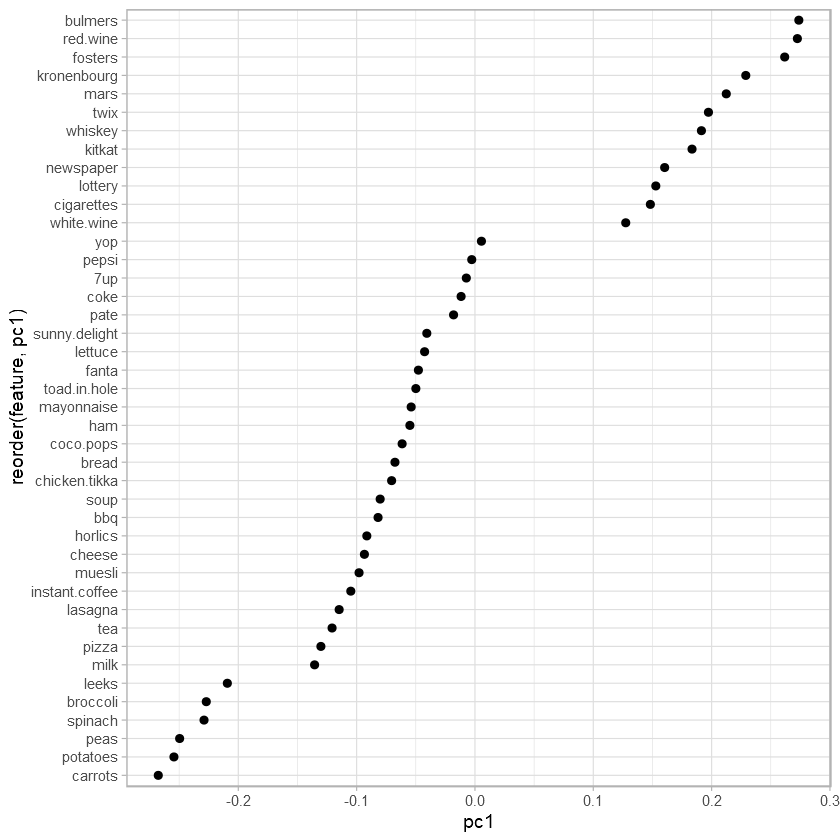

In [24]:
infl %>% as.data.frame() %>%
    mutate(feature = row.names(eigen)) %>%
    ggplot(aes(pc1, reorder(feature, pc1))) + 
    geom_point()

#### PC의 비교

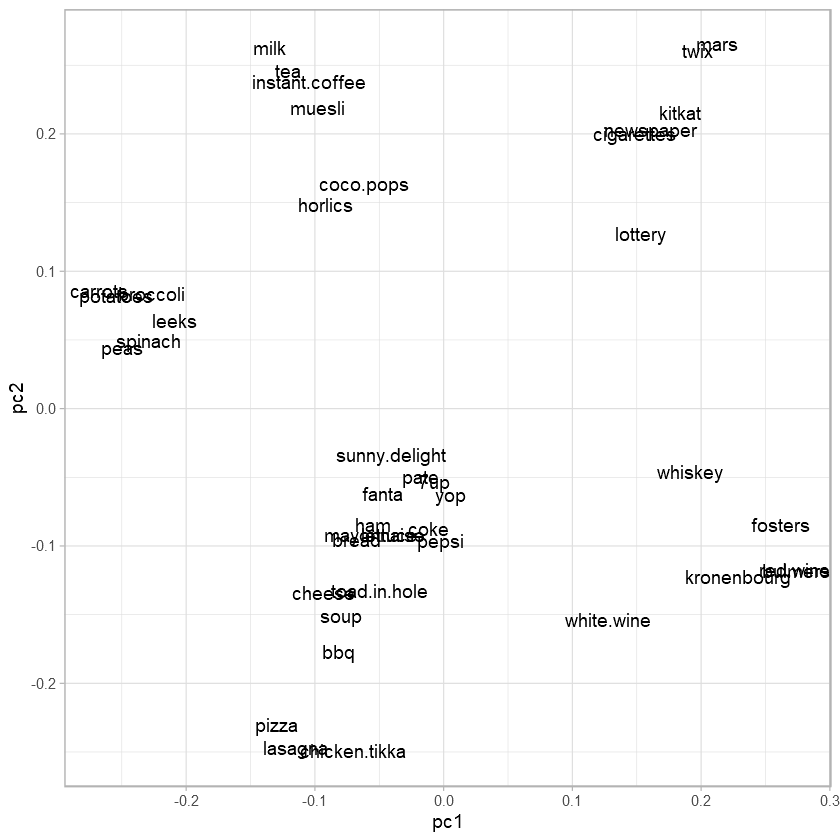

In [22]:
my_pca@model$eigenvectors %>% 
  as.data.frame() %>% 
  mutate(feature = row.names(.)) %>%
  ggplot(aes(pc1, pc2, label = feature)) +
  geom_text()

### 주성분의 수 선택
1. 고유값 기준
2. 설명된 분산비율 (PVE)기준
3. Scree Plot 기준

### 1. 고유값 기준
- 고유값의 총합 = 변수의 개수
- 고유값이 1이면 주성분이 한 변수의 변동성에 대해 설명 할 수 있음을 의미
- 각 주성분이 최소 하나의 변수의 변동성을 설명해야함
- **고유값 기준은 고유값이 1보다 큰 주성분만 유지**

In [34]:
eigen <- my_pca@model$importance 
eigen

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,1.51391887,1.47376825,1.45911373,1.44063487,1.43527873,1.41154352,1.2533073,1.0263865,1.01023787,1.00725266,...,0.82642212,0.81853215,0.81379580,0.80438044,0.79607343,0.79378138,0.78061498,0.77861208,0.76343330,0.74969641
Proportion of Variance,0.05457025,0.05171412,0.05069078,0.04941497,0.04904821,0.04743941,0.0373995,0.0250826,0.02429954,0.02415614,...,0.01626127,0.01595226,0.01576818,0.01540543,0.01508888,0.01500212,0.01450857,0.01443421,0.01387691,0.01338202
Cumulative Proportion,0.05457025,0.10628436,0.15697514,0.20639012,0.25543833,0.30287774,0.3402772,0.3653598,0.38965938,0.41381552,...,0.86658143,0.88253369,0.89830187,0.91370730,0.92879618,0.94379829,0.95830686,0.97274107,0.98661798,1.00000000


In [42]:
eigen1 <- eigen['Standard deviation',] %>% as.vector() %>% .^2
eigen1

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,2.29195,2.171993,2.129013,2.075429,2.060025,1.992455,1.570779,1.053469,1.020581,1.014558,...,0.6829735,0.6699949,0.6622636,0.6470279,0.6337329,0.6300889,0.6093598,0.6062368,0.5828304,0.5620447


In [36]:
sum(eigen1)

[1] 42

In [38]:
which(eigen1 >= 1)

[1]  1  2  3  4  5  6  7  8  9 10

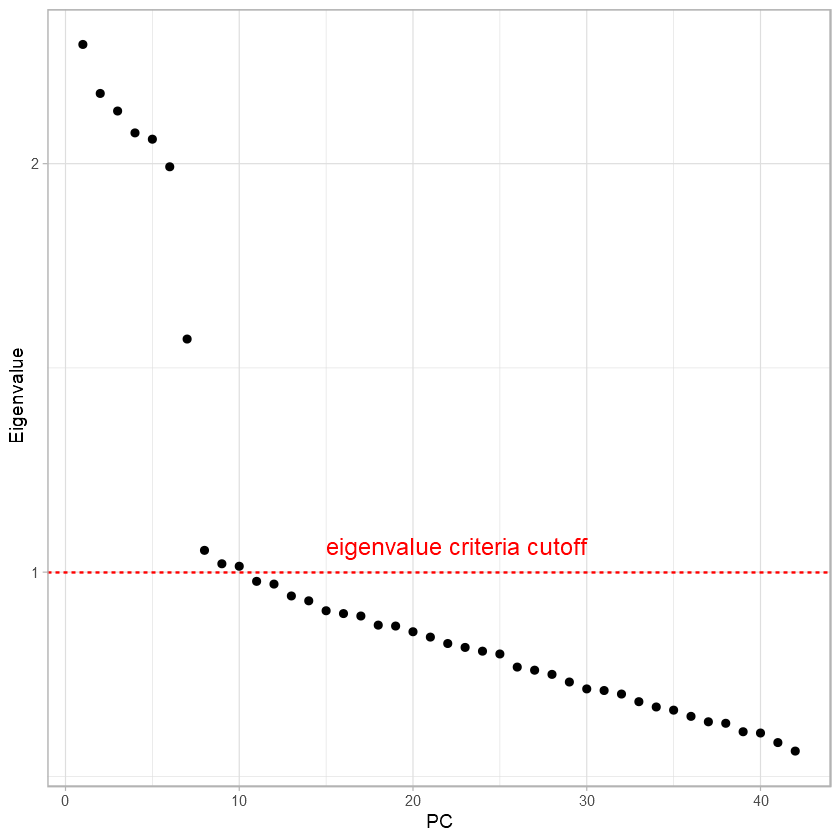

In [41]:
data.frame(
  PC = seq_along(eigen1),
  Eigenvalue = unlist(eigen1)
) %>%
  ggplot(aes(PC, Eigenvalue)) +
  geom_point() +
  geom_hline(yintercept = 1, lty = "dashed", color = "red") +
  scale_y_continuous(breaks = 0:6) +
  xlab("PC") +
  annotate("text", x = 15, y = 1, label = "eigenvalue criteria cutoff", color = "red", size = 5, hjust = 0, vjust = -1) 

### 2. 설명된 분산비율 (PVE)기준

In [45]:
my_pca@model$importance

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,1.51391887,1.47376825,1.45911373,1.44063487,1.43527873,1.41154352,1.2533073,1.0263865,1.01023787,1.00725266,...,0.82642212,0.81853215,0.81379580,0.80438044,0.79607343,0.79378138,0.78061498,0.77861208,0.76343330,0.74969641
Proportion of Variance,0.05457025,0.05171412,0.05069078,0.04941497,0.04904821,0.04743941,0.0373995,0.0250826,0.02429954,0.02415614,...,0.01626127,0.01595226,0.01576818,0.01540543,0.01508888,0.01500212,0.01450857,0.01443421,0.01387691,0.01338202
Cumulative Proportion,0.05457025,0.10628436,0.15697514,0.20639012,0.25543833,0.30287774,0.3402772,0.3653598,0.38965938,0.41381552,...,0.86658143,0.88253369,0.89830187,0.91370730,0.92879618,0.94379829,0.95830686,0.97274107,0.98661798,1.00000000


In [47]:
ve <- data.frame(
  PC  = my_pca@model$importance %>% seq_along(),
  PVE = my_pca@model$importance %>% .[2,] %>% unlist(),
  CVE = my_pca@model$importance %>% .[3,] %>% unlist()
) 
ve %>% head

,PC,PVE,CVE
,<int>,<dbl>,<dbl>
pc1,1,0.05457025,0.05457025
pc2,2,0.05171412,0.10628436
pc3,3,0.05069078,0.15697514
pc4,4,0.04941497,0.20639012
pc5,5,0.04904821,0.25543833
pc6,6,0.04743941,0.30287774


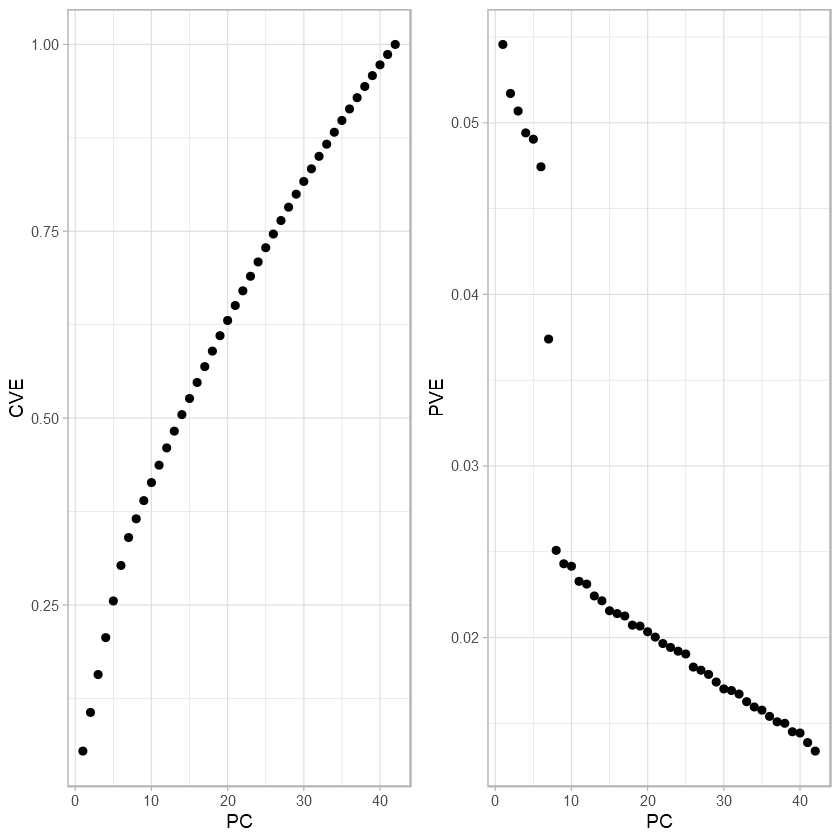

In [52]:
p1 <- ggplot(ve) + geom_point(aes(PC, CVE))
p2 <- ggplot(ve) + geom_point(aes(PC, PVE))
gridExtra::grid.arrange(p1, p2, nrow = 1)

- 설명된 분산의 누적비, 개별 분산비

#### 원 데이터 변동성의 75%를 설명하는데 필요한 PC의 수

In [53]:
min(which(ve$CVE >= 0.75))

[1] 27

### Scree Plot 기준

In [74]:
ve %>% head

,PC,PVE,CVE
,<int>,<dbl>,<dbl>
pc1,1,0.05457025,0.05457025
pc2,2,0.05171412,0.10628436
pc3,3,0.05069078,0.15697514
pc4,4,0.04941497,0.20639012
pc5,5,0.04904821,0.25543833
pc6,6,0.04743941,0.30287774


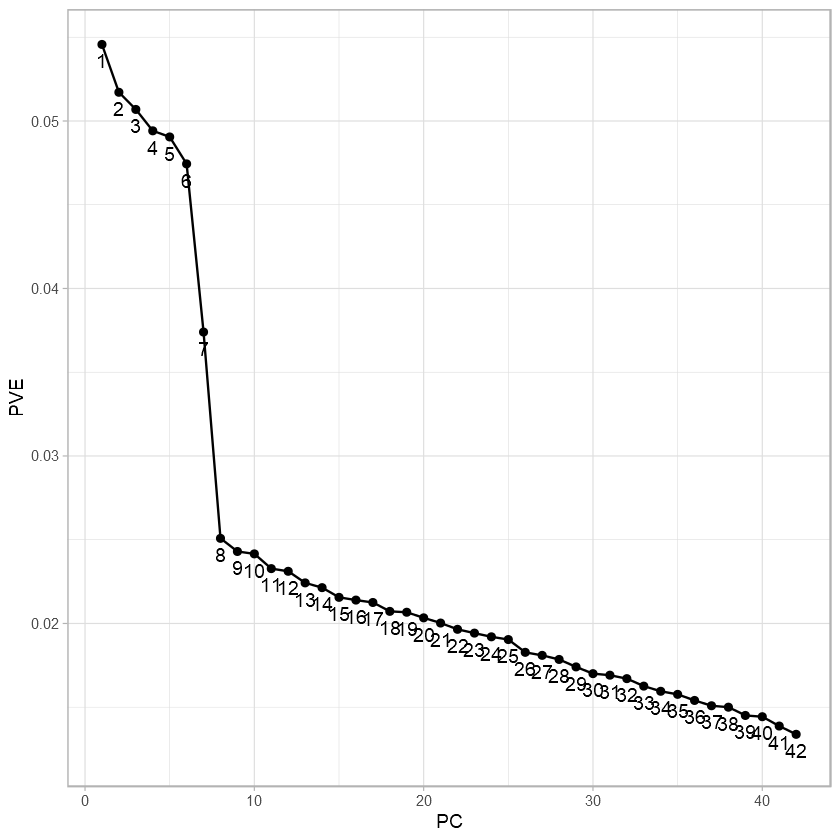

In [83]:
ggplot(ve, aes(PC, PVE, label = PC)) + geom_point() + geom_line() + geom_text(nudge_y = -.001)

#### Scree Plot이 평평해지기 직전의 값 : 8 